# Code for testing statistical arbitrage strategy on Equity Futures on the NSE 

In [2]:
#Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pyfolio as pf

In [3]:
#reading data from csv file and changing the index to date time index

data = pd.read_csv('closing prices.csv', index_col=0)
data.index = pd.to_datetime(data.index, unit='s')
data.head()

acc  auropharma  axisbank  bajajauto  biocon  \
time                                                                    
2018-01-01 03:45:00  1742.00      688.90    566.60     3312.4  269.73   
2018-01-02 03:45:00  1744.90      675.45    560.00     3309.1  271.65   
2018-01-03 03:45:00  1779.00      669.45    561.10     3259.6  272.10   
2018-01-04 03:45:00  1802.95      672.10    560.35     3281.0  272.05   
2018-01-05 03:45:00  1810.20      673.95    563.95     3292.1  271.92   

                     britannia   cipla   dabur  divislab  drreddy  ...  \
time                                                               ...   
2018-01-01 03:45:00    2377.27  616.50  351.10   1106.75  2420.80  ...   
2018-01-02 03:45:00    2341.05  610.65  350.25   1085.45  2421.50  ...   
2018-01-03 03:45:00    2349.52  608.30  355.75   1103.75  2348.15  ...   
2018-01-04 03:45:00    2325.02  617.45  356.55   1108.50  2417.50  ...   
2018-01-05 03:45:00    2334.27  616.00  359.25   1110.85  2477.50  ...   

                     mindtree  nestleind    sbin  sunpharma  tatamotors  \
time                                                                      
2018-01-01 03:45:00    610.70    7897.15  309.10     576.20      426.85   
2018-01-02 03:45:00    606.95    7905.80  304.60     574.70      440.75   
2018-01-03 03:45:00    602.85    7901.40  304.45     571.45      434.85   
2018-01-04 03:45:00    603.20    7888.80  309.70     584.40      430.70   
2018-01-05 03:45:00    603.70    7865.00  307.90     581.60      431.75   

                         tcs  tech_m   wipro  shreecem  ultracemco  
time                                                                
2018-01-01 03:45:00  1328.57  505.80  229.54  17976.90     4286.55  
2018-01-02 03:45:00  1317.43  514.85  233.74  18056.85     4266.80  
2018-01-03 03:45:00  1316.13  519.15  229.24  18187.70     4316.65  
2018-01-04 03:45:00  1325.20  522.05  230.70  18087.40     4363.90  
2018-01-05 03:45:00  1341.70  524.55  229.69  19016.10     4399.80  

[5 rows x 32 columns]

In [4]:
# defining a function to find cointegrated pairs on a dataset with critical value set at -2.87

def find_cointegrated_pairs(dataframe, critical_level=-2.87):
    columns = dataframe.shape[1]
    keys = dataframe.keys()
    cointegrated_pairs = []

    for i in range(columns):
        for j in range(i+1, columns):
            df1 = dataframe[keys[i]]
            df2 = dataframe[keys[j]]
            model = sm.OLS(df1.iloc[:100], df2.iloc[:100])
            model = model.fit()
            h_ratio = model.params[0]
            spread = df1 - (df2 * h_ratio)
            adf = adfuller(spread, maxlag=1)[0]
            if adf < critical_level:
                rows = [keys[i], keys[j], adf]
                cointegrated_pairs.append(rows)
    cointegrated_pairs = pd.DataFrame(cointegrated_pairs, columns=[
                             'pair_1', 'pair_2', 't_statistics'])
    return cointegrated_pairs

In [5]:
def strategy(dataset,ma_lookback,std_dev):

    def backtest(df1, df2, ma_lookback, std_dev):

        df = pd.DataFrame({'df1':df1, 'df2':df2})

    # Calculate the spread using hedge ratio
        model = sm.OLS(df1, df2)
        model = model.fit()
        h_ratio = model.params[0]
        df['spread'] = df1 - (h_ratio * df2)

#-------------------------------------------------------------------------------------------    
    
    # Bollinger Band calculation 
        moving_average = df.spread.rolling(ma_lookback).mean()
        moving_std_dev = df.spread.rolling(ma_lookback).std()
        upper_band = moving_average + std_dev*moving_std_dev
        lower_band = moving_average - std_dev*moving_std_dev
    
#--------------------------------------------------------------------------------------------

    # Signal generation    
    
    # Long positions
        long_entry = df.spread < lower_band
        long_exit = df.spread >= moving_average
        df['positions_long'] = np.nan
        df.loc[long_entry, 'positions_long'] = 1
        df.loc[long_exit, 'positions_long'] = 0
        df.positions_long = df.positions_long.fillna(method='ffill')

    # Short positions
        short_entry = df.spread > upper_band
        short_exit = df.spread <= moving_average
        df['positions_short'] = np.nan
        df.loc[short_entry, 'positions_short'] = -1
        df.loc[short_exit, 'positions_short'] = 0
        df.positions_short = df.positions_short.fillna(method='ffill')

    # Positions
        df['positions'] = df.positions_long + df.positions_short

#--------------------------------------------------------------------------------------

    # Cumulative returns
        df['percentage_change'] = (
        df.spread - df.spread.shift(1))/(abs(model.params[0])*df1 + df2)
        df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
        df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
    
        return  df['cumulative_returns'],df['strategy_returns'] #returning both types of returns
    

#creating two dataframes to store cumulative returns and strategy returns separately
    results = pd.DataFrame() #to store cumulative returns
    returns = pd.DataFrame() #to store strategy returns

    for i in np.arange(cointegrated_pairs.shape[0]):

        pair_1 = cointegrated_pairs.iloc[i][0]
        pair_2 = cointegrated_pairs.iloc[i][1]

        name = pair_1 + "-" + pair_2

        df1 = dataset[pair_2] #
        df2 = dataset[pair_1] #

        temp,temp1 = backtest(df1, df2, ma_lookback, std_dev) #added temp1 variable

        results[name] = temp.values #cumulative returns
        returns[name] = temp1.values #strategy returns
    

# Plot cumulative returns of all individual pairs
    results.index = dataset.index #
    results.plot(figsize=(12,7),grid=True)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
    plt.show()


#let us construct a portfolio for these cointegrated pairs with equal weights 
#assuming the entire portfolio weight =1, the weighting of each pair would be 1 divided by the length of the cointegrating list, 
#all being the same as all the pair weights are equal

    initial_weight=[] #empty list 

    i = 0
    pair_weight = (1/len(cointegrated_pairs))

    while i<len(cointegrated_pairs): 
        initial_weight.append(pair_weight)  
        i+=1                               



    returns['strategy_returns'] = returns.dot(initial_weight) #storing portfolio returns into new column
    


#using the pyfolio library to calculate portfolio metrics
    returns.index = dataset.index #
    pf.create_simple_tear_sheet(returns['strategy_returns'])
    

### In sample testing to find out the best parameters

In [6]:
# Possible values of moving average lookback period to try out
lookback = [20,35,50]

# Possible values of Bollinger Band standard deviation period to try out
std_dev = [0.5,2,3]

In [7]:
print(lookback, std_dev)

[20, 35, 50] [0.5, 2, 3]


In [8]:
# Split the data to optimize and validate the parameter
train_length = int(len(data)*0.7)
train_set = pd.DataFrame(data[:train_length])
test_set = pd.DataFrame(data[train_length:])

In [9]:
#finding the cointegrated pairs 
cointegrated_pairs = find_cointegrated_pairs(train_set)
cointegrated_pairs

pair_1        pair_2  t_statistics
0            acc       hcltech     -3.290977
1            acc        tech_m     -3.187622
2            acc    ultracemco     -2.969150
3       axisbank       drreddy     -3.060948
4       axisbank           tcs     -2.968080
5       axisbank         wipro     -2.995680
6      bajajauto       hcltech     -3.755004
7      bajajauto           tcs     -3.018713
8      bajajauto        tech_m     -3.669695
9         biocon    tatamotors     -3.019707
10         cipla  indusindbank     -2.938899
11         cipla      mindtree     -3.332116
12         dabur          infy     -3.161084
13         dabur           tcs     -3.107546
14       drreddy       hcltech     -3.307984
15       drreddy      hdfcbank     -2.945018
16       drreddy          infy     -3.395836
17       drreddy           tcs     -3.430491
18       drreddy        tech_m     -3.365426
19      godrejcp        maruti     -3.250092
20      godrejcp    tatamotors     -2.953839
21       hcltech          sbin     -3.066393
22       hcltech        tech_m     -3.112223
23       hcltech      shreecem     -3.024873
24       hcltech    ultracemco     -3.227453
25      hdfcbank          sbin     -2.981922
26      hdfcbank           tcs     -3.169990
27     heromotor  indusindbank     -3.012062
28     heromotor      mindtree     -2.987481
29  indusindbank        maruti     -3.454384
30  indusindbank      mindtree     -3.022481
31  indusindbank    tatamotors     -3.460653
32          infy        marico     -3.345079
33          infy          sbin     -3.079872
34          infy           tcs     -3.409900
35        maruti      mindtree     -3.127293
36      mindtree     sunpharma     -2.893563
37      mindtree    tatamotors     -3.581817
38          sbin           tcs     -3.398613
39          sbin        tech_m     -3.112013
40          sbin      shreecem     -3.297545
41    tatamotors        tech_m     -3.323156
42           tcs      shreecem     -3.010449
43        tech_m    ultracemco     -2.906127

#### Using For loop to try all the possible combinations of Moving Average lookback and Bollinger Band Std.Dev 

-------------------------------------------------------------------------------------------------------
moving average look back is :  20
Bollinger Band Std Dev is :  0.5
****results are below*********


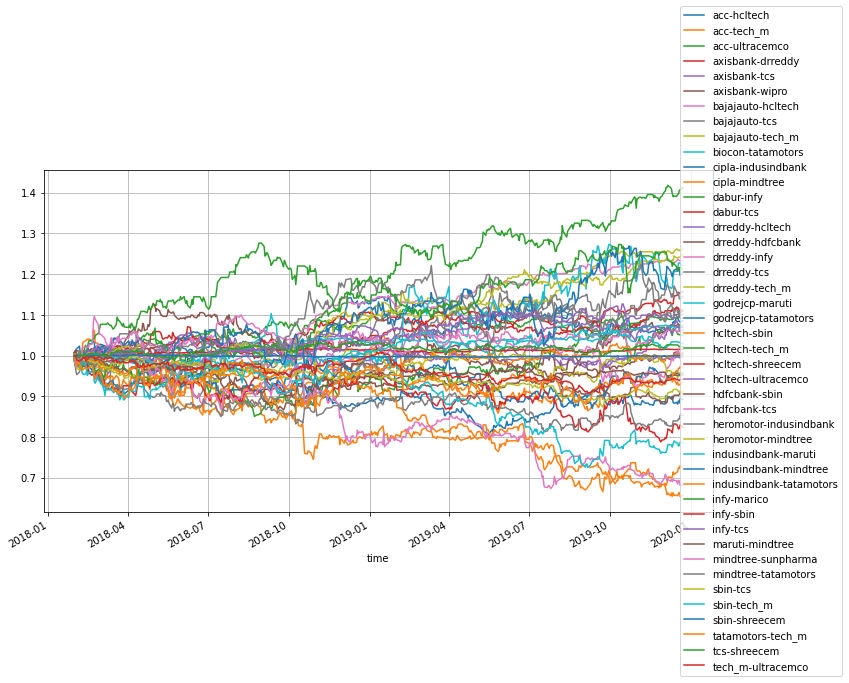

-------------------------------------------------------------------------------------------------------
moving average look back is :  20
Bollinger Band Std Dev is :  2
****results are below*********


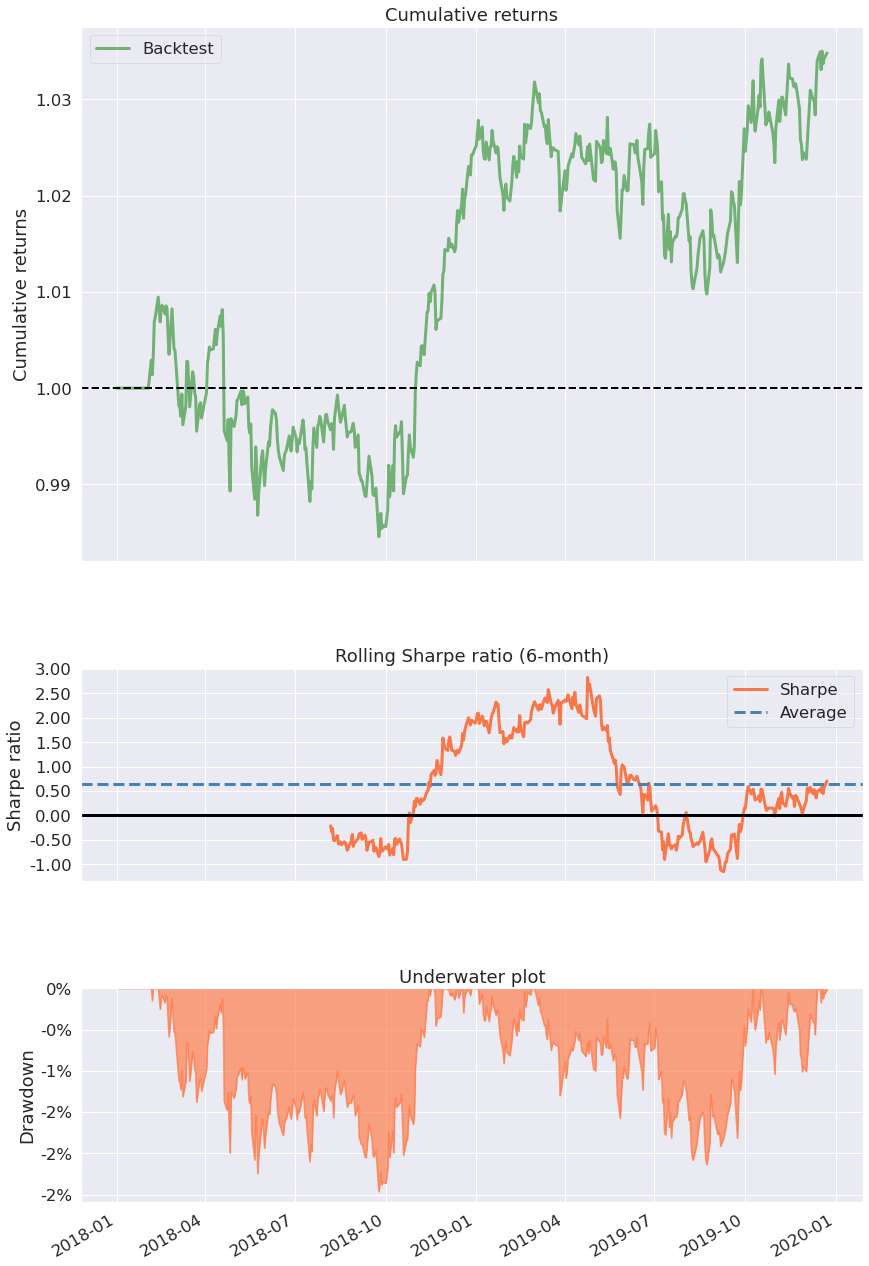

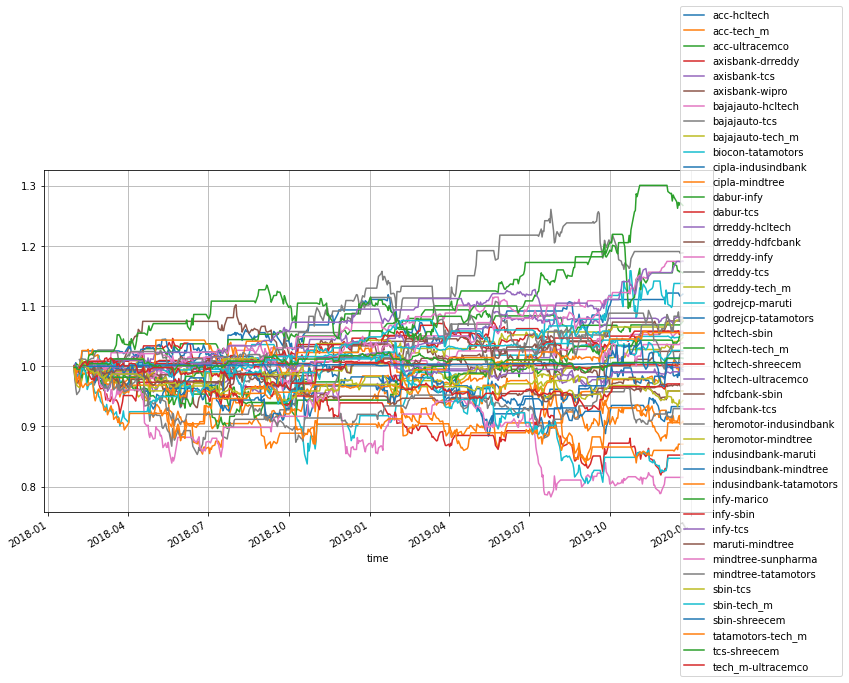

-------------------------------------------------------------------------------------------------------
moving average look back is :  20
Bollinger Band Std Dev is :  3
****results are below*********


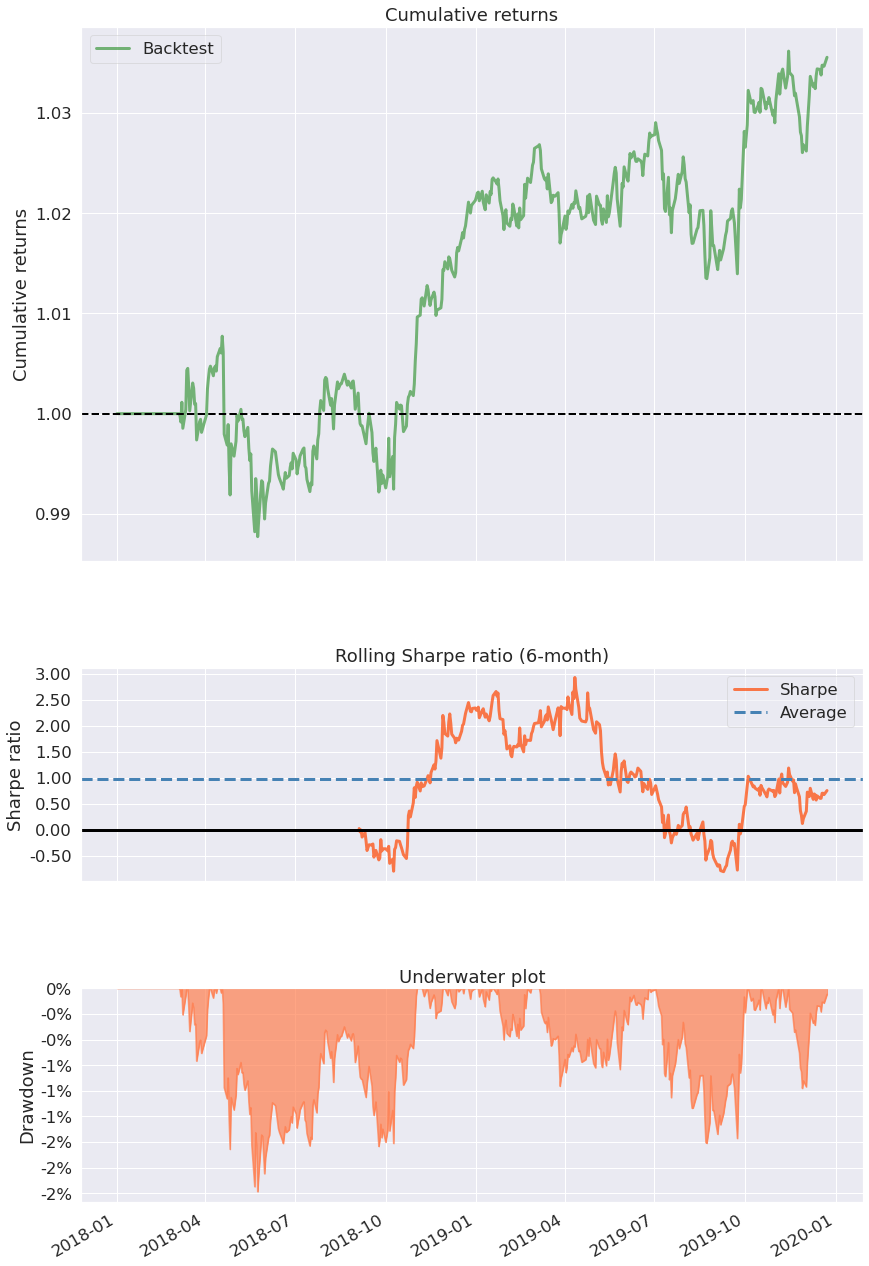

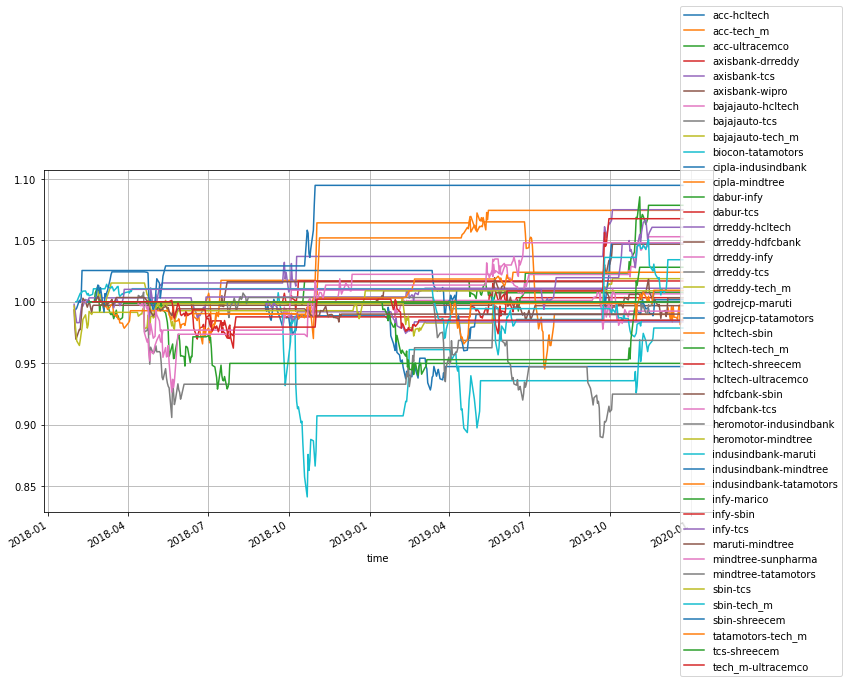

-------------------------------------------------------------------------------------------------------
moving average look back is :  35
Bollinger Band Std Dev is :  0.5
****results are below*********


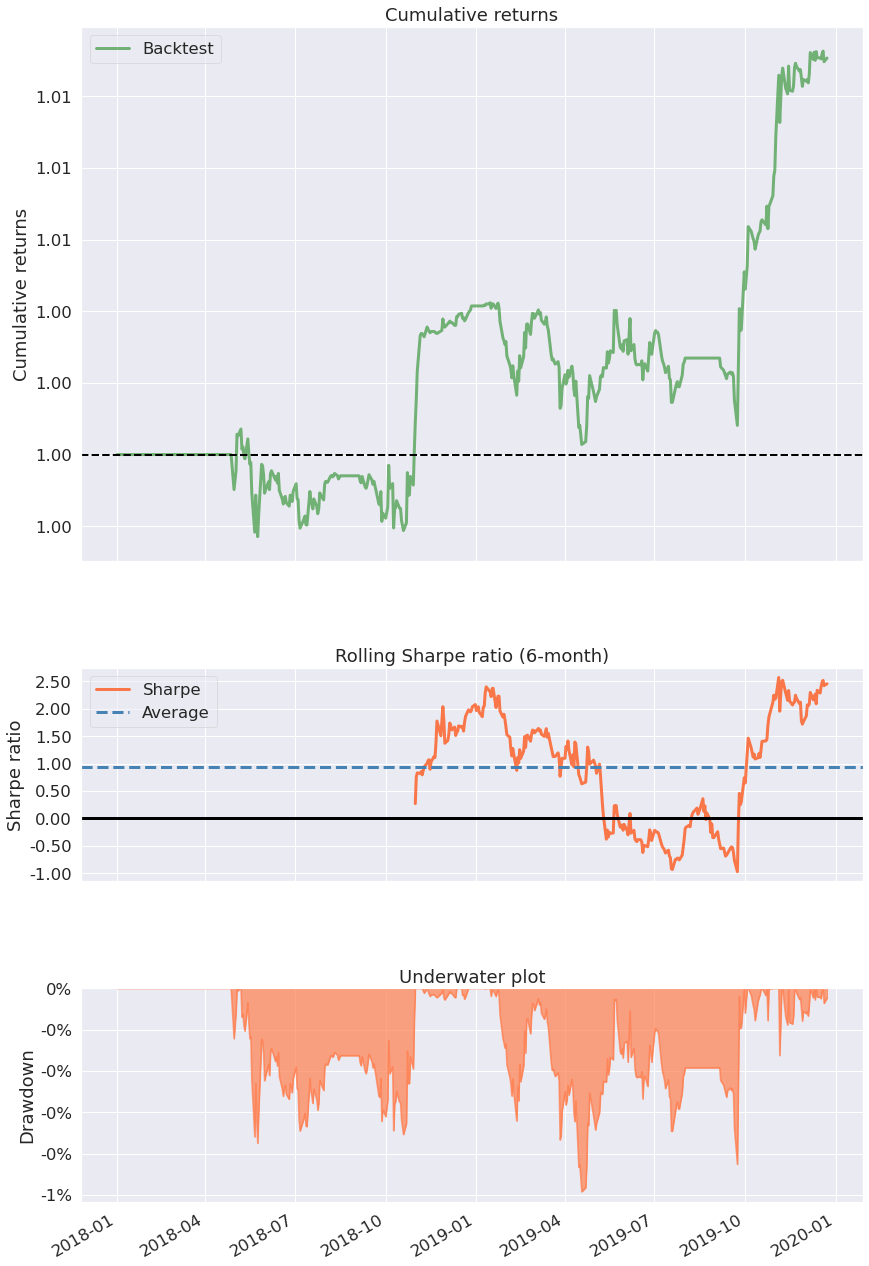

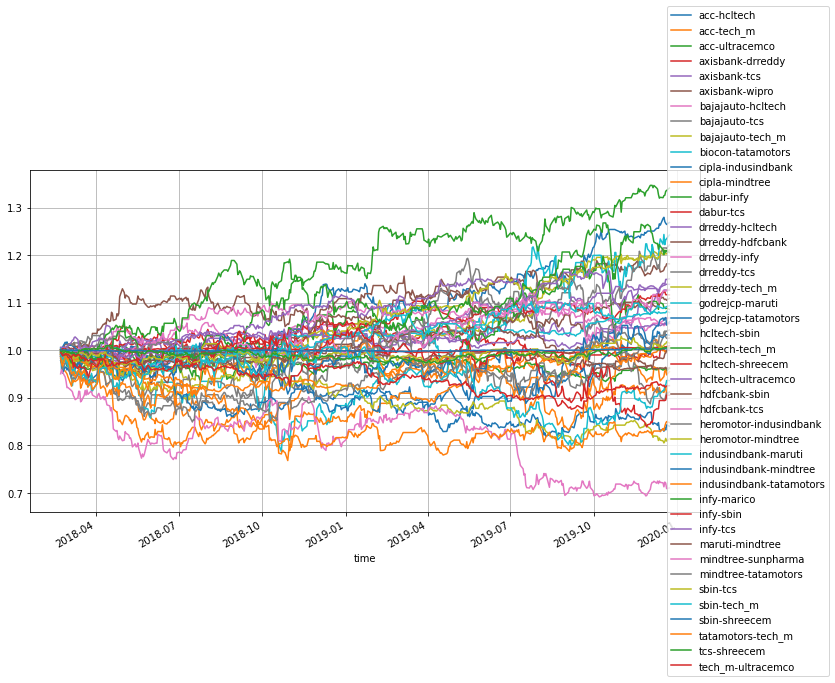

-------------------------------------------------------------------------------------------------------
moving average look back is :  35
Bollinger Band Std Dev is :  2
****results are below*********


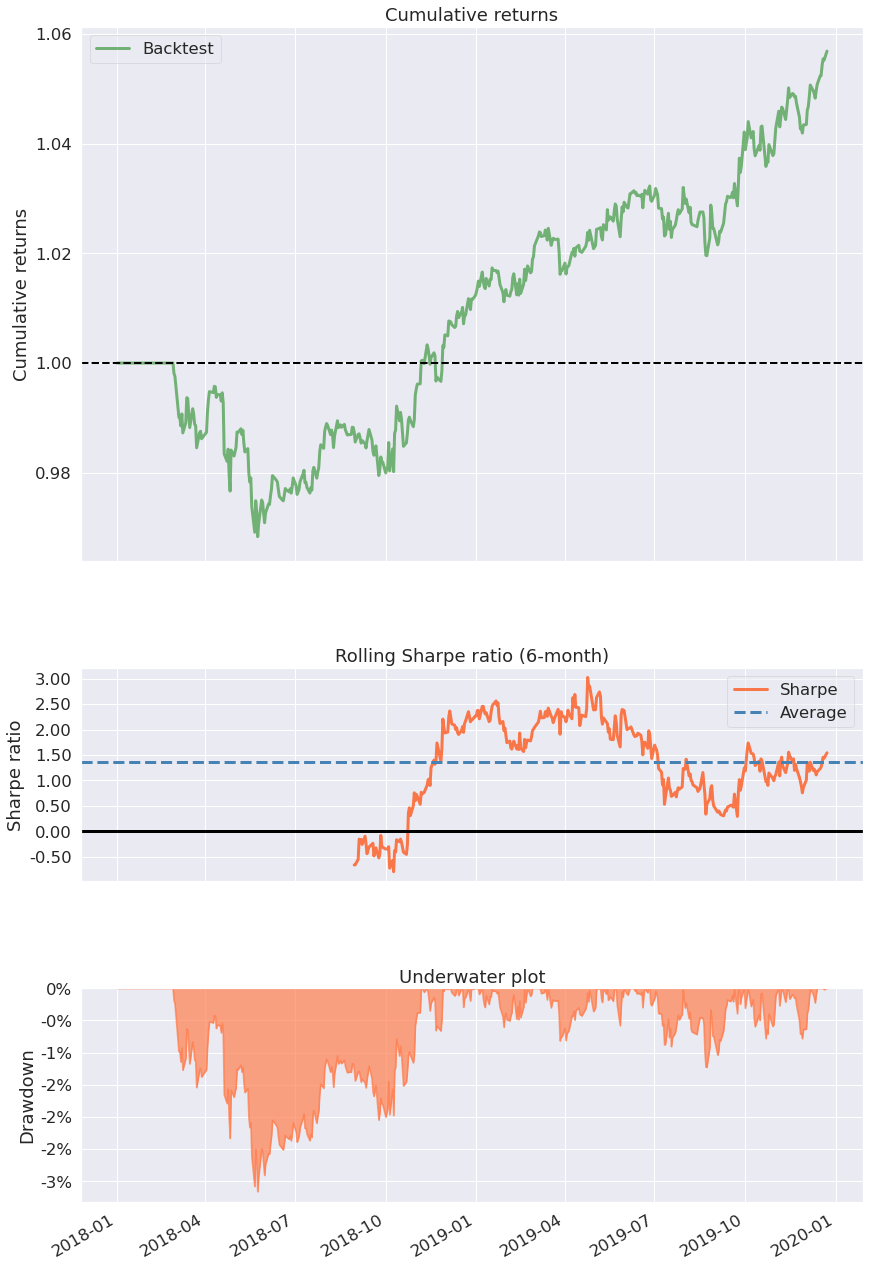

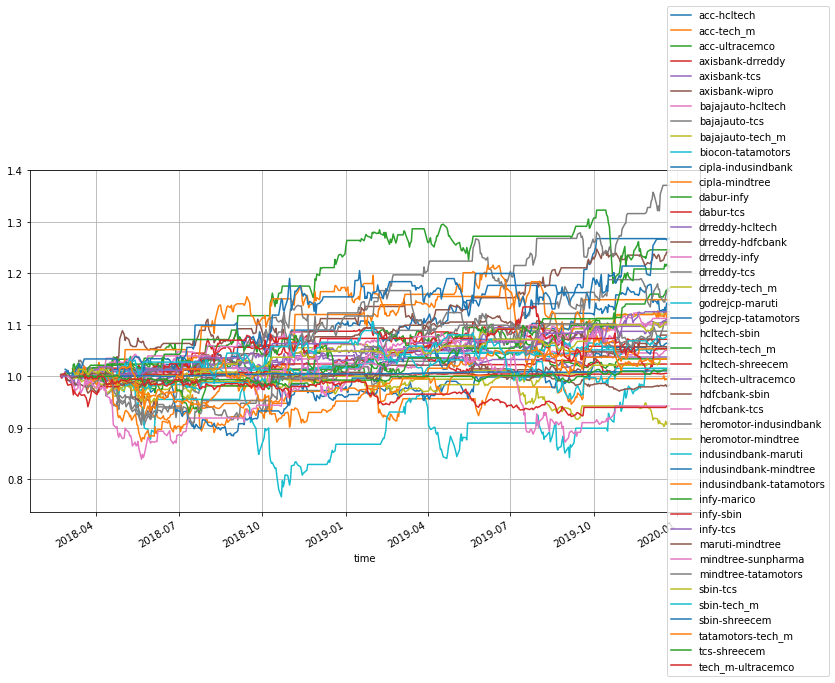

-------------------------------------------------------------------------------------------------------
moving average look back is :  35
Bollinger Band Std Dev is :  3
****results are below*********


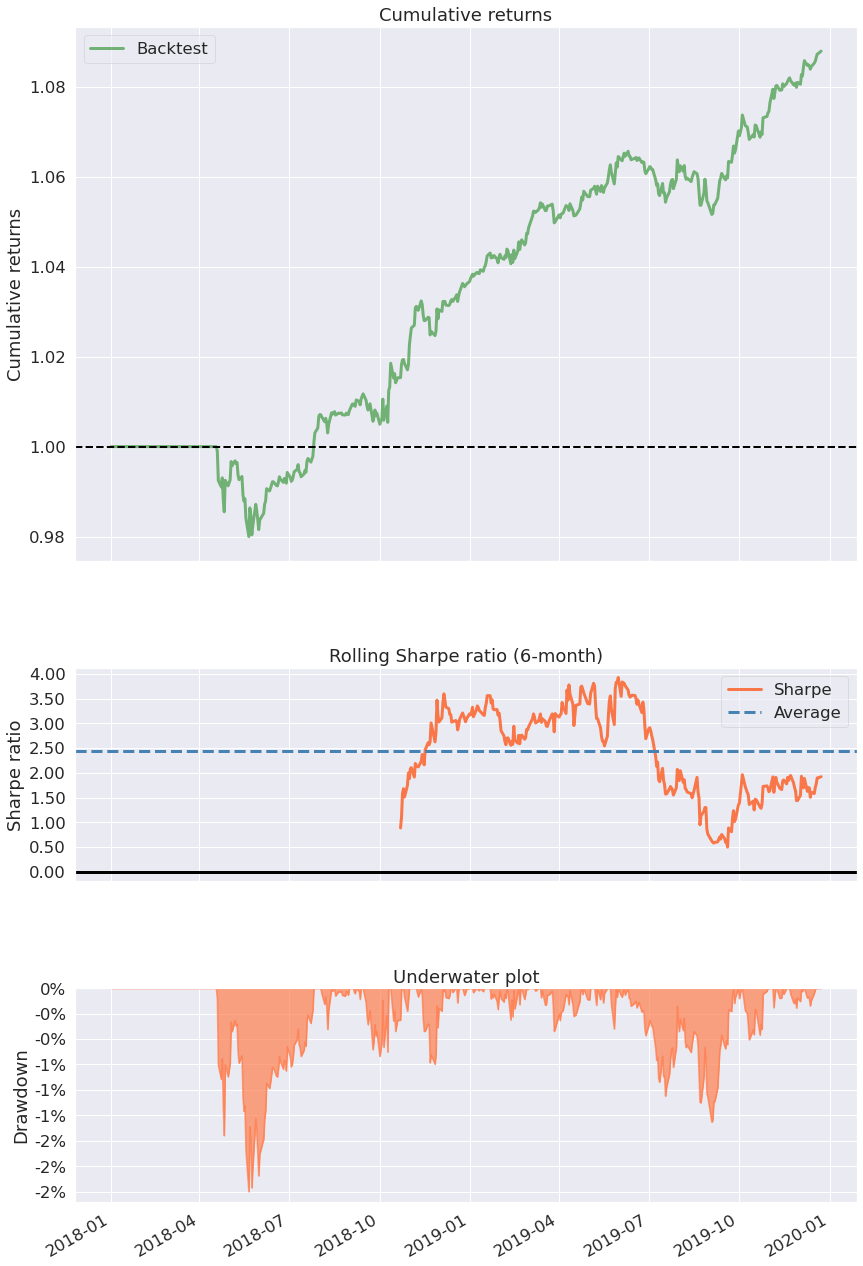

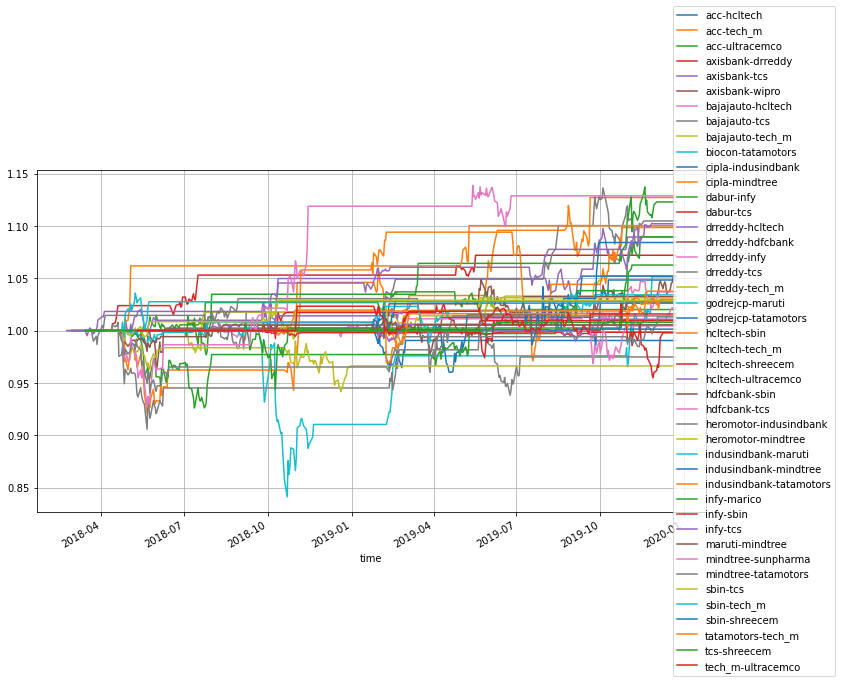

-------------------------------------------------------------------------------------------------------
moving average look back is :  50
Bollinger Band Std Dev is :  0.5
****results are below*********


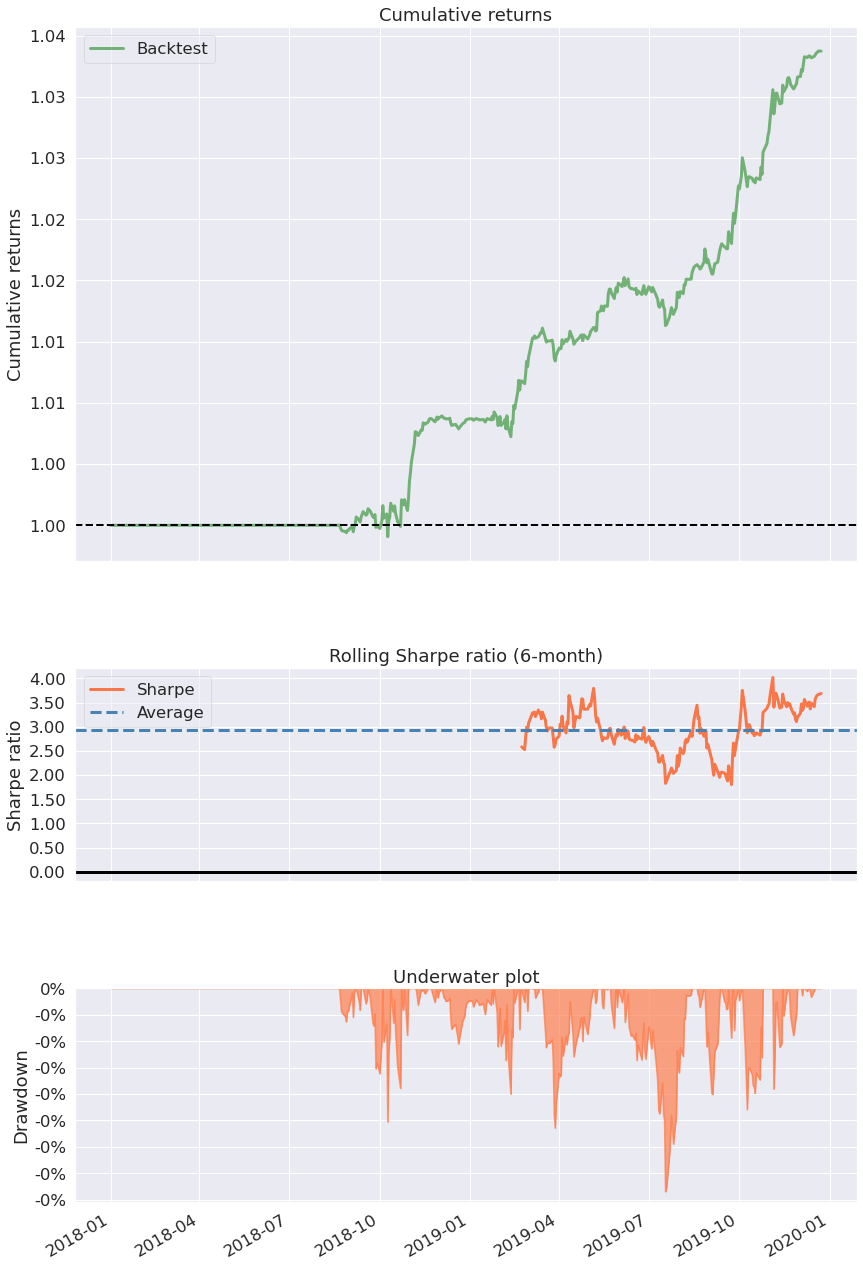

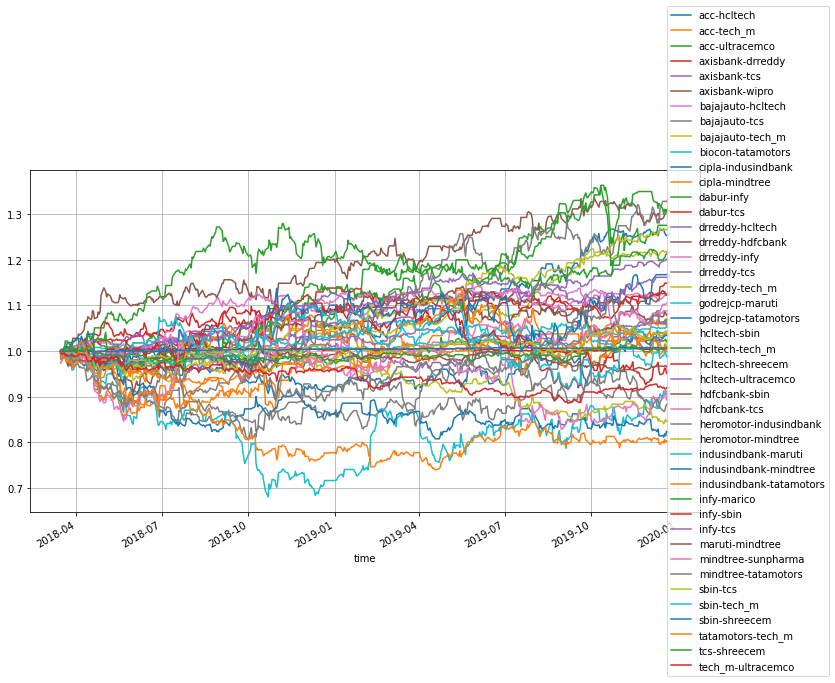

-------------------------------------------------------------------------------------------------------
moving average look back is :  50
Bollinger Band Std Dev is :  2
****results are below*********


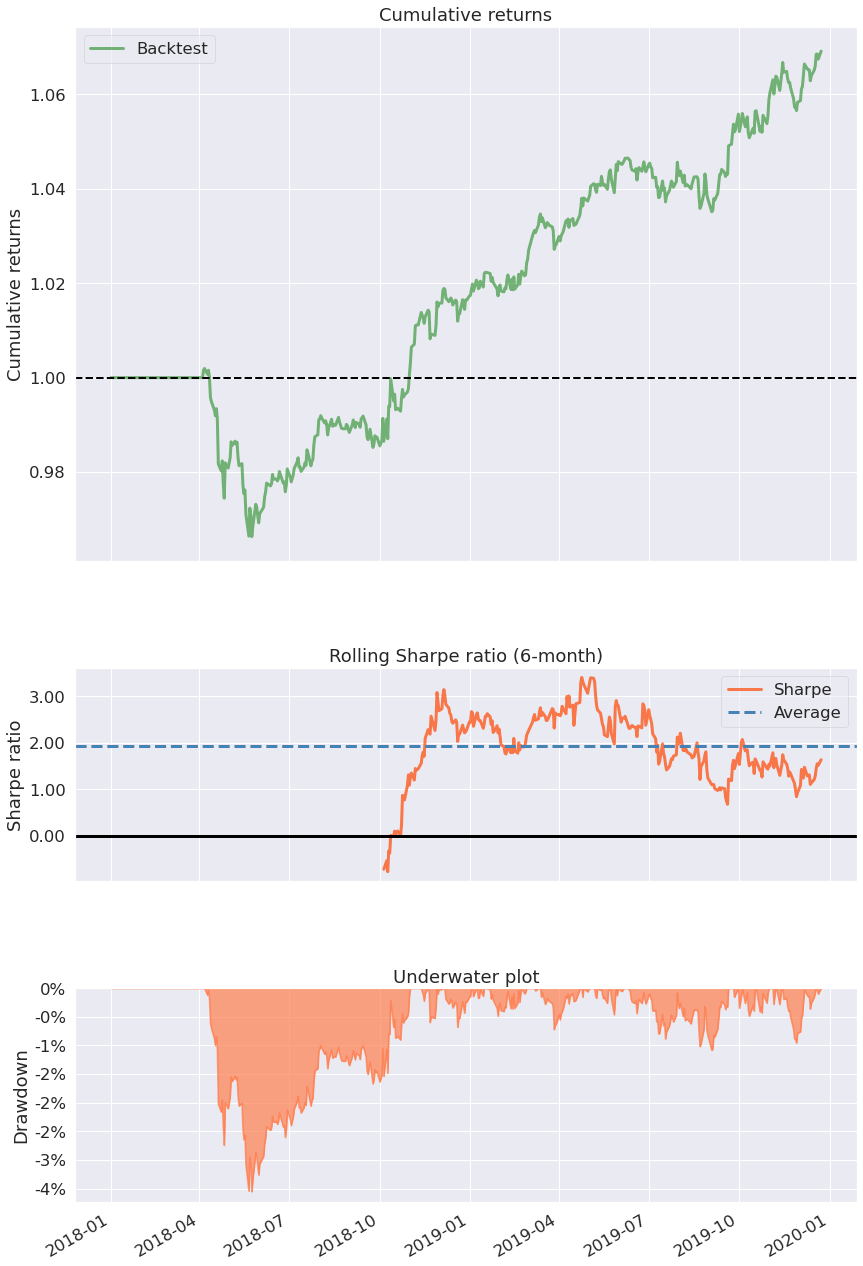

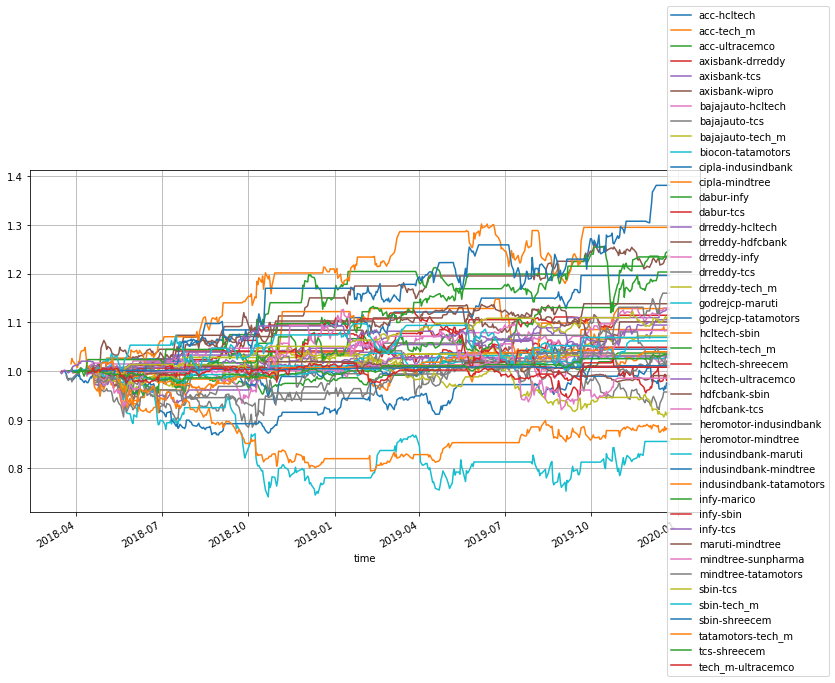

-------------------------------------------------------------------------------------------------------
moving average look back is :  50
Bollinger Band Std Dev is :  3
****results are below*********


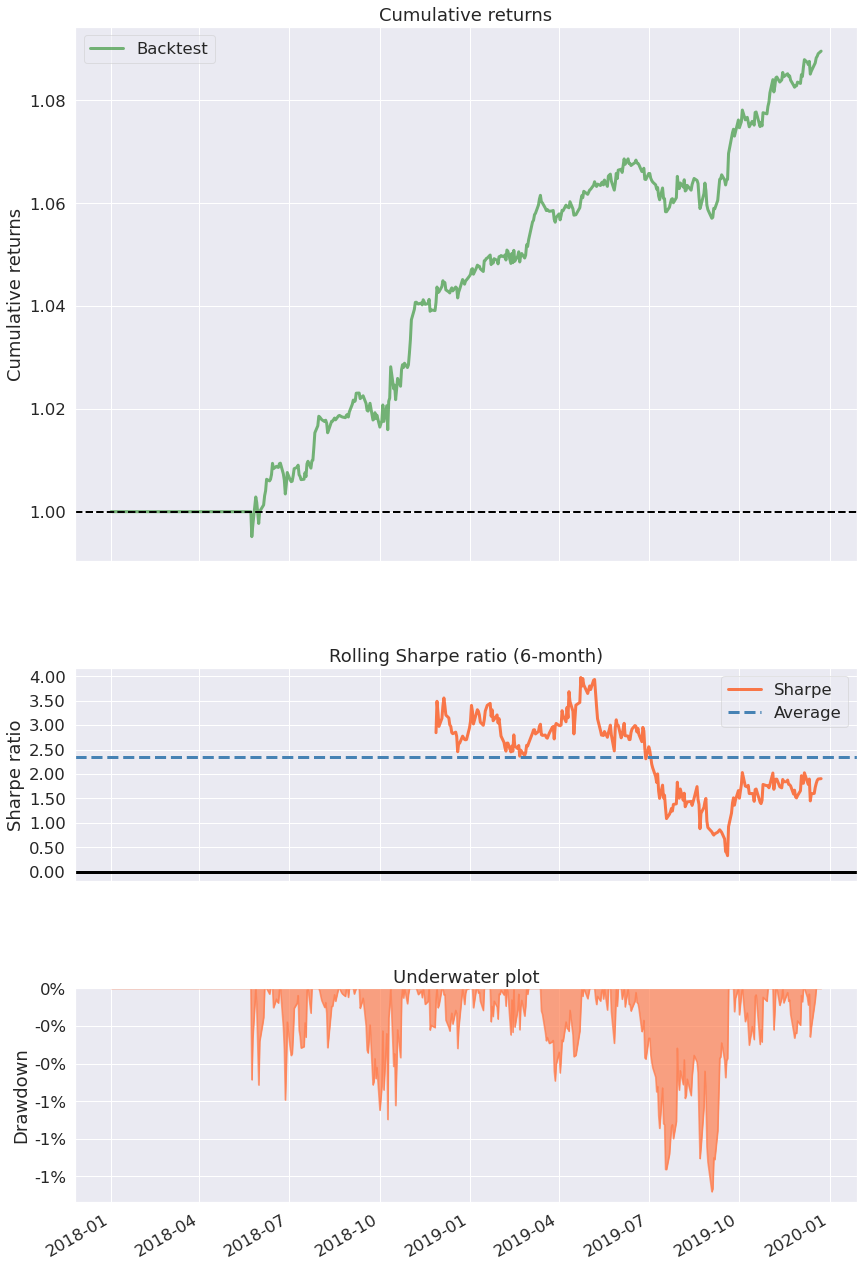

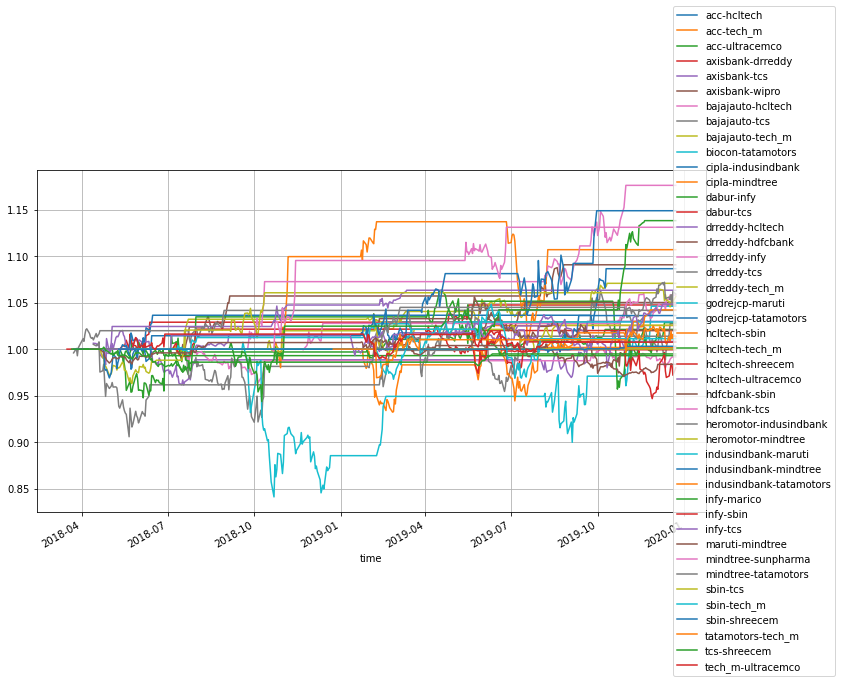

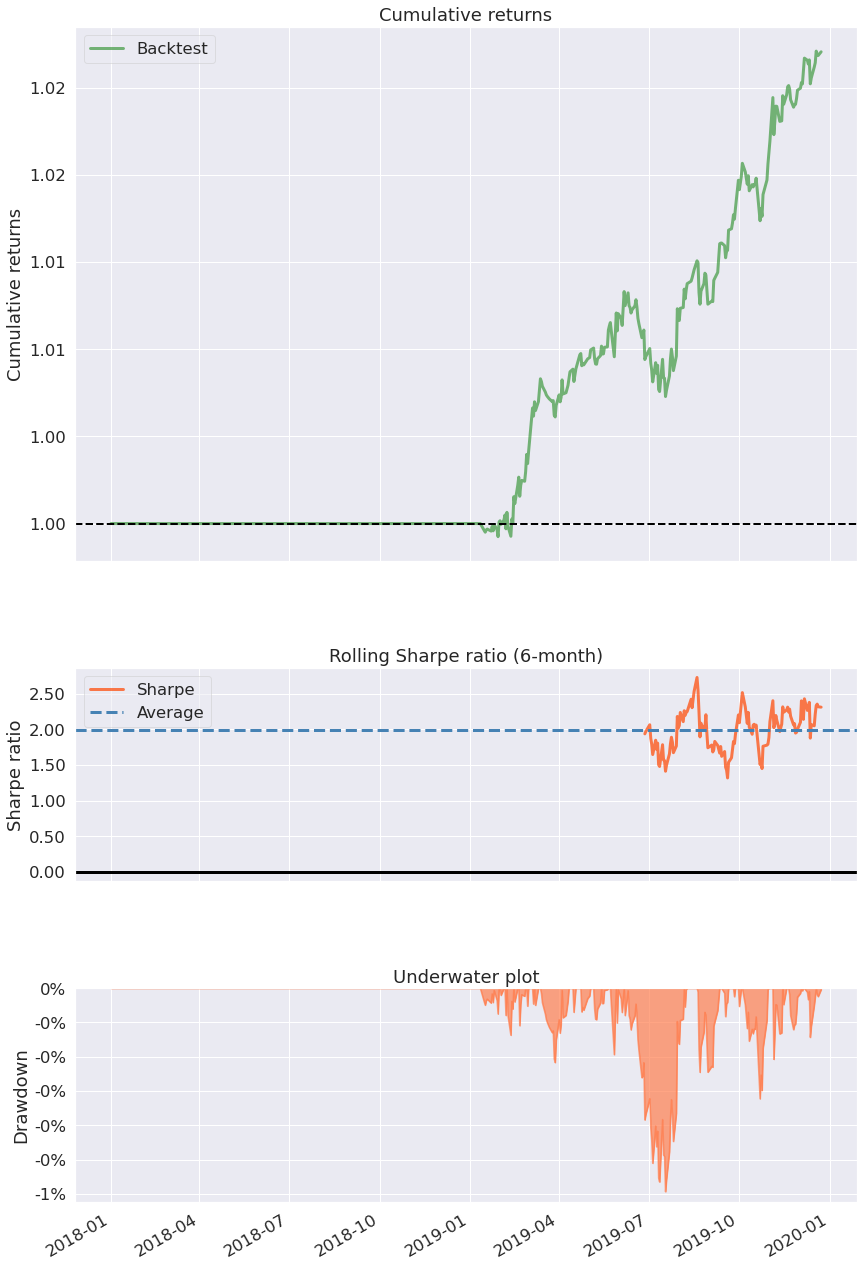

In [10]:
for i in range(len(lookback)):
    for j in range(len(std_dev)):
        print('-------------------------------------------------------------------------------------------------------')
        print("moving average look back is : ",lookback[i])
        print("Bollinger Band Std Dev is : ",std_dev[j])
        print('****results are below*********')
        strategy(train_set,lookback[i],std_dev[j])

### Out of sample testing

In [ ]:
#from the above output, the best results are from the (35,3) and (50,2) from the train set.Now we will input these parameters 
#on the test data set to see how well the strategy performs in out of sample data

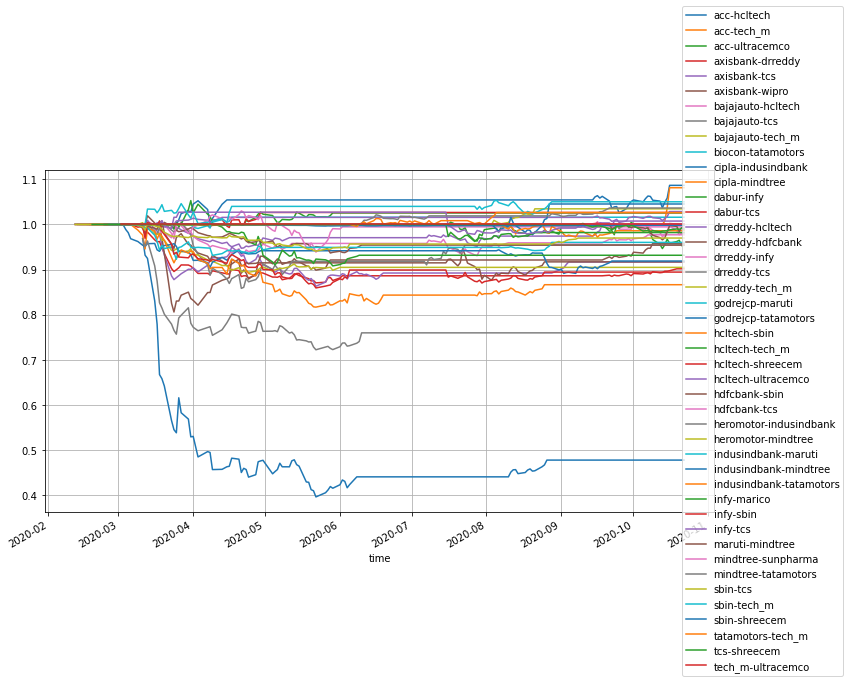

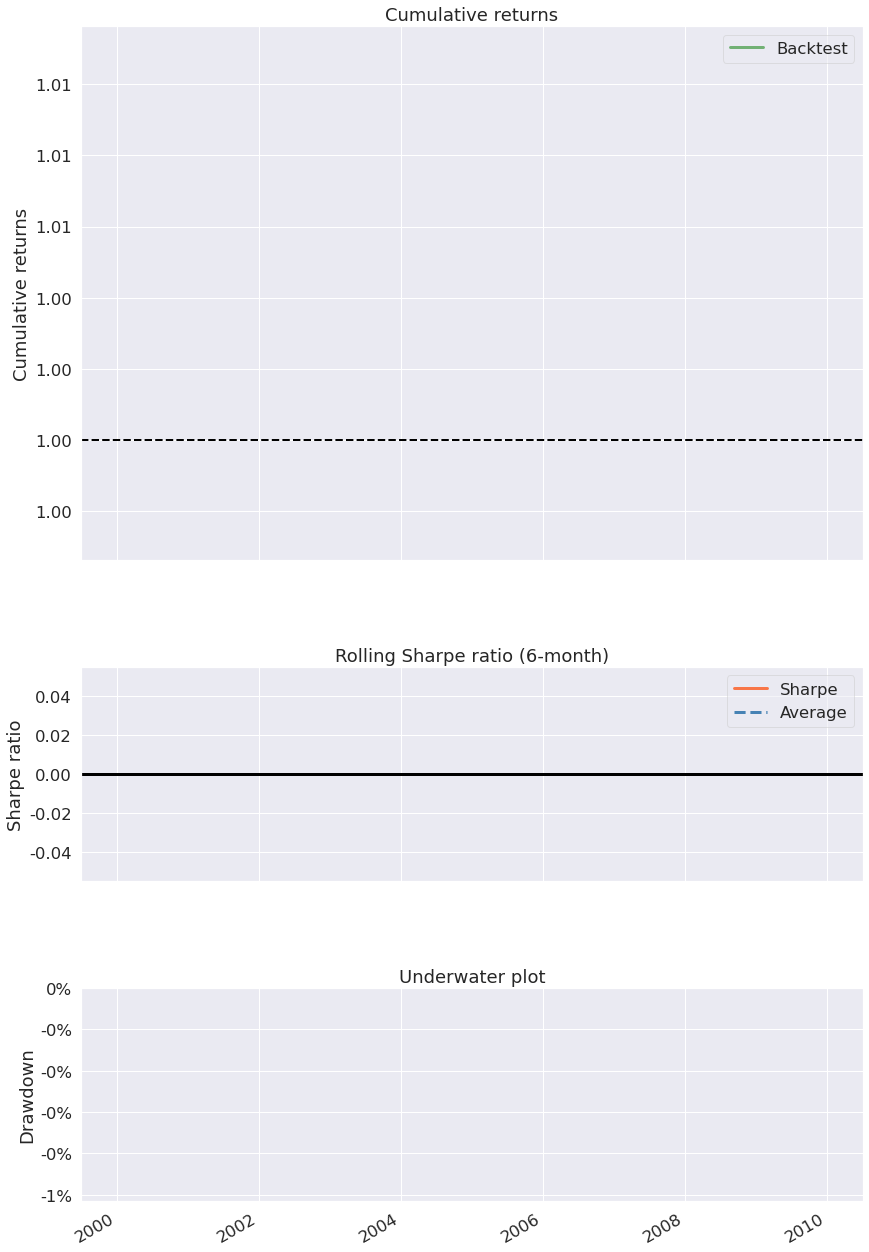

In [11]:
#Applying lookback = 35 and Bollinger Band Std.Dev of 3 on the test set
strategy(test_set,35,3)

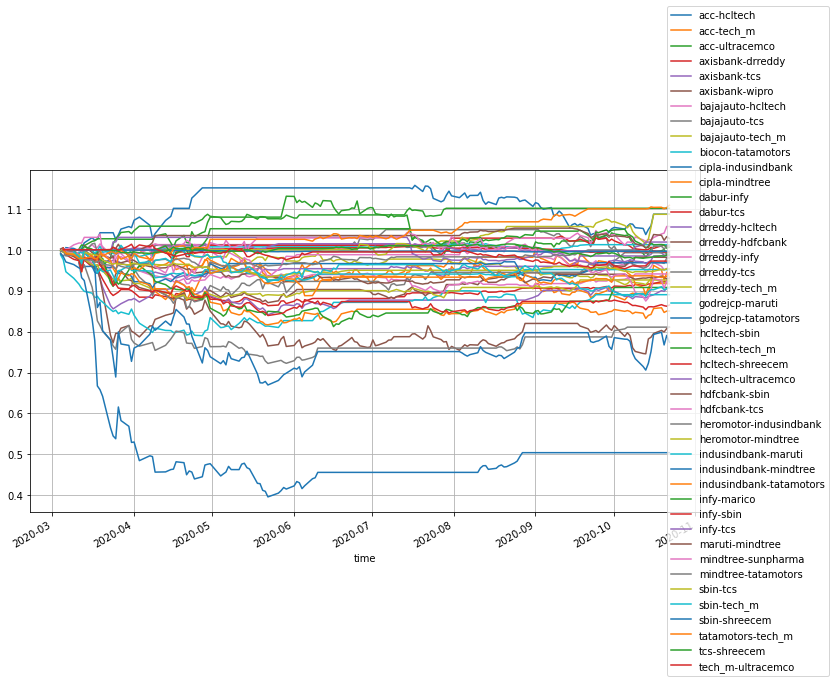

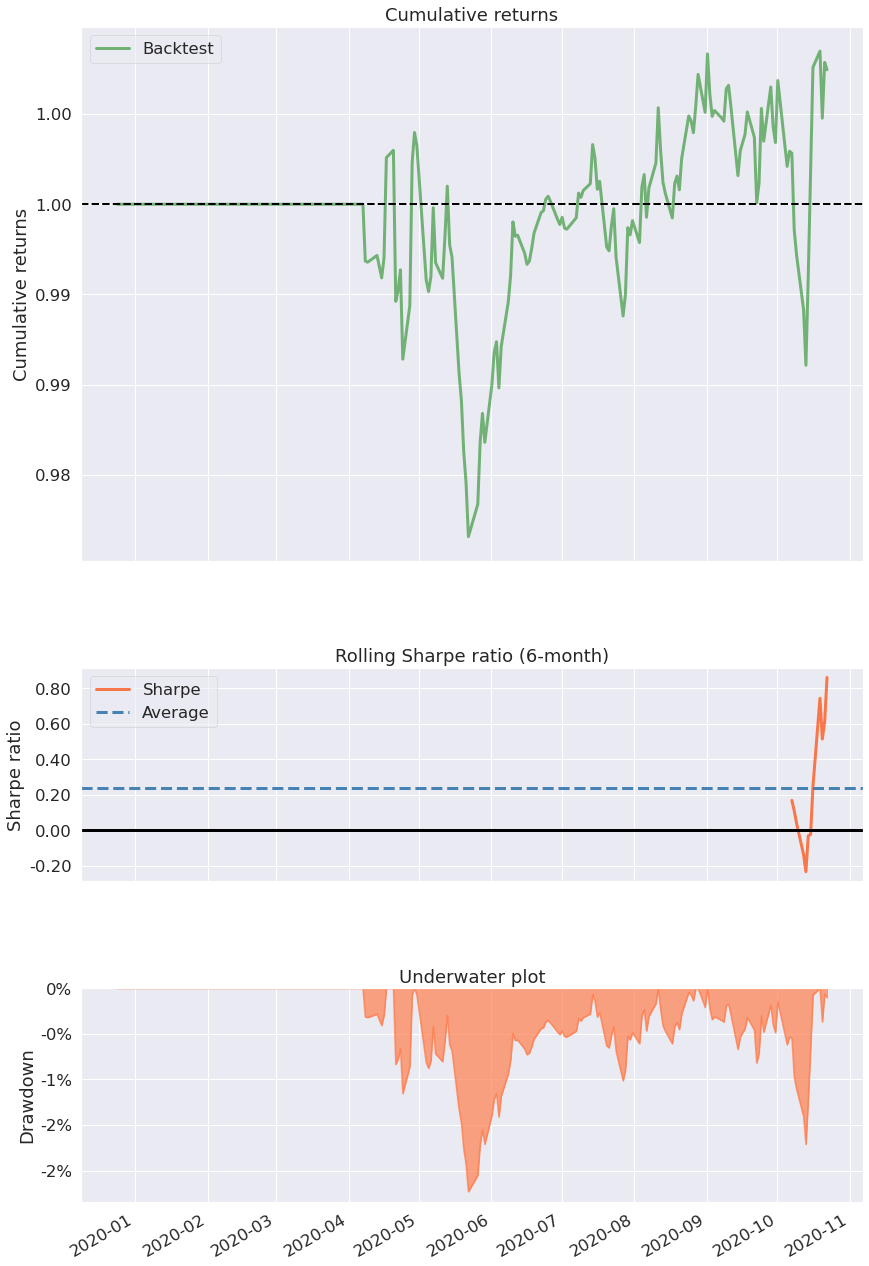

In [12]:
#Applying lookback = 50 and Bollinger Band Std.Dev of 2 on the test set
strategy(test_set,50,2)

In [ ]:
#from above output, the best returns with respect to the risk are obtained by (35,3) in the test data set